In [13]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

# working with arrays
import numpy as np

# plotting functionality
import matplotlib.pyplot as plt
import seaborn as sns

# typehints
from typing import Tuple

"""
Own packages
"""
from codelib.visualization.base import risk_waterfall_chart, waterfall_chart

from codelib.visualization.layout import DefaultStyle
DefaultStyle();

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Allocating diversification benefits

## Measuring diversification benefits

Above we defined the portfolio standard deviation using matrix notation 

$$
\sigma_P(\mathbf{w}) = \sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}
$$

Since portfolio standard deviation is sub-additive, then it must always hold that

$$
\sigma_P(\mathbf{w}) \leq \sum_{i=1}^N w_i \sigma_i = \mathbf{w}^\top \mathbf{v}
$$

where $\mathbf{v}$ is a vector of volatilities. We can define the diversification benefit directly as the difference between the weighted sum of the individual volatilities and the portfolio volatility 

$$
\text{Div}_{B} = \mathbf{w}^\top \mathbf{v} - \sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}
$$

or normalized by the weighted sum of the individual volatilities

$$
\text{Div}_{RB} = \frac{\mathbf{w}^\top \mathbf{v} - \sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}}{\mathbf{w}^\top \mathbf{v}}
$$

### Example: Diversification benefit from investing in stocks and bonds

Consider a two asset example with stocks (S) and bonds (B). Stocks are defined by $\mu_S = 0.04, \sigma_S = 0.15$ and bonds are defined by $\mu_B = 0.01, \sigma_B = 0.075$. The correlation between stocks and bonds is $\rho _{S,B} = 0.2$. 

What is the diversification benefits with an equal allocation to stocks and bonds?

In [14]:
"""
Define relevant information 
"""

w_eq = np.array([0.5, 0.5])

sigma_s = 0.15
sigma_b = 0.075
rho = 0.2

vols = np.array([sigma_s, sigma_b])
corr_mat = np.array([[1.0, rho], [rho, 1.0]])
cov_mat = np.outer(vols, vols) * corr_mat

"""
Define a function that calculates portfolio standard deviation
"""

def portfolio_std(weights: np.ndarray, cov_matrix: np.ndarray) -> float:
    
    """
    Function that returns the standard deviation of the portfolio
    
    Parameters
    ----------
    weights: 
        Portfolio weights
    cov_matrix: 
        Covariance matrix
    
    Returns
    -------
    float
        Standard deviation of portfolio
    """
    
    return np.sqrt(weights @ cov_matrix @ weights)

"""
Calculate diversification benefit
"""
total_port_risk = portfolio_std(w_eq, cov_mat)
div_benefit = total_port_risk - w_eq @ vols

print('The diversification benefit is equal to {:.2f}%'.format(div_benefit * 100))

The diversification benefit is equal to -2.22%


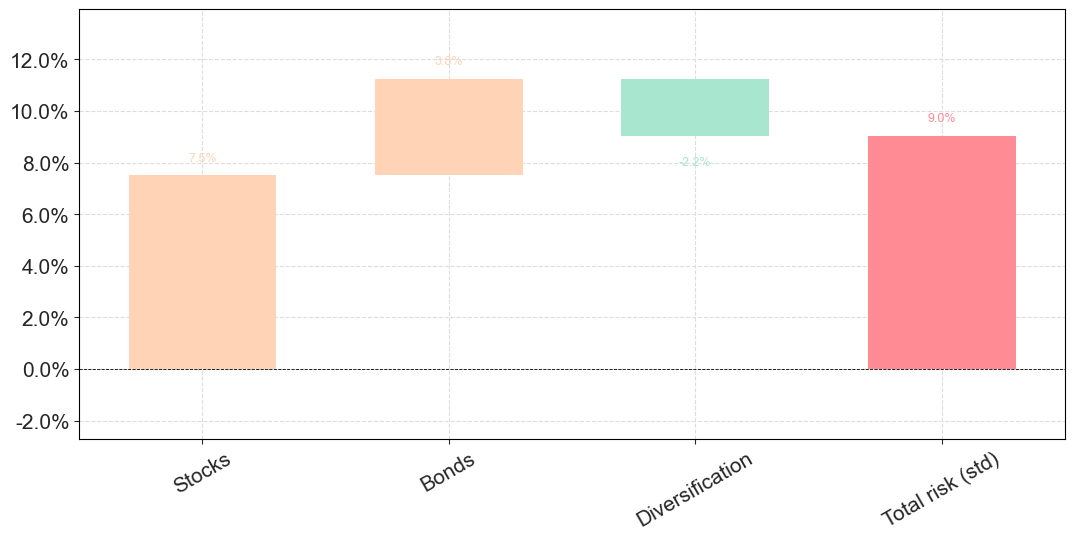

In [15]:
"""
Plot a waterfall chart with risk decomposition 
"""

fig, ax = risk_waterfall_chart(vols * w_eq * 100, total_port_risk*100, names=["Stocks", "Bonds"],
                     formatting='{:,.1f}%', total_risk_label="Total risk (std)", diversification_label="Diversification");


fig.set_size_inches(12, 6)

## How to allocate diversification benefits

We have just looked at how to calculate the diversification benefit, but how can the diversification benefit be allocated between the different asset classes? We want to know what the risk contribution of a particular asset is when taking the diversification into account. Several methods have been proposed, but we will only present the most commonly used. 

Since standard deviation satisfies the positiv homogeneity assumption, i.e. standard deviation is homogeneous of degree one, then it follows from the [Euler's homogeneous function theorem](https://en.wikipedia.org/wiki/Homogeneous_function) that (see e.g. [Bruder and Roncalli (2012)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2009778))

$$
\sigma_P(\mathbf{w}) = \mathbf{w}^\top \nabla \sigma_P(\mathbf{w}) = \sum_{i=1}^N w_i \frac{\partial \sigma_P(\mathbf{w}) }{\partial w_i}
$$

The portfolio standard deviation (and true risk measures that satisfy the positive homogeneity requirement) can be written as the sum of the product of the exposure, $w_i$, by its marginal risk, $\frac{\partial }{\partial w_i}\sigma_P(\mathbf{w})$. We therefore define the risk contribution of asset $i$ as
 
$$
\text{RC}_i(\mathbf{w}) = w_i \frac{\partial \sigma_P(\mathbf{w}) }{\partial w_i}
$$

Using the chain rule and [matrix calculus](https://en.wikipedia.org/wiki/Matrix_calculus), the gradient is given by

$$
\nabla \sigma_P(\mathbf{w}) = \frac{d \sigma_P(\mathbf{w}) }{d \mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}\frac{\partial \mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}{\partial \mathbf{w}} = \frac{1}{2\sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}} 2 \boldsymbol{\Sigma} \mathbf{w} = \frac{\boldsymbol{\Sigma} \mathbf{w} }{\sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}}
$$

Hence, we have that 

$$
\sigma_P(\mathbf{w}) = \mathbf{w}^\top \frac{\boldsymbol{\Sigma} \mathbf{w} }{\sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}} = \sum_{i=1}^N w_i \frac{(\boldsymbol{\Sigma} \mathbf{w})_i }{\sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}}
$$

### Example 

Consider a two asset example from above. What is the risk contribution of stocks and bonds respectivly?



In [16]:
def calculate_marginal_risks(weights: np.ndarray, cov_matrix: np.ndarray) -> np.ndarray:
    
    """
    Function that calculates marginal risk
    Parameters
    ----------
    weights: 
        Portfolio weights
    cov_matrix: 
        Covariance matrix
    
    Returns
    -------
    np.ndarray
        Marginal risks
    """
    
    total_risk = np.sqrt(weights @ cov_matrix @ weights)
    inner_derivative = cov_matrix @ weights
    
    return inner_derivative / total_risk

def calculate_risk_contributions(weights: np.ndarray, cov_matrix: np.ndarray) -> np.ndarray:
    
    """
    Function that calculates risk contributions
    
    Parameters
    ----------
    weights: 
        Portfolio weights
    cov_matrix: 
        Covariance matrix
    
    Returns
    -------
    np.ndarray
        Marginal risks
    """
    
    mr = calculate_marginal_risks(weights, cov_matrix)
    
    return weights * mr

risk_contrib = calculate_risk_contributions(w_eq, cov_mat)
print("Risk contribution:")
print("Stocks: {:.2f}%'".format(risk_contrib[0] * 100))
print("Bonds: {:.2f}%'".format(risk_contrib[1] * 100))

Risk contribution:
Stocks: 6.85%'
Bonds: 2.18%'


## Equal risk contribution 

There is a large literature on *risk parity investing* where the focus is on allocating risk instead of capital, e.g. we want an equal amount of risk coming from bonds and stocks. We will talk more about this later in the course, but we will give a very brief introduction. The problem that we want to solve is 

$$
w_i \frac{(\boldsymbol{\Sigma} \mathbf{w})_i }{\sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}} = b_i \sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}
$$

where $b_i$ is the risk coming from the $i$'th asset. In addition, we would likely impose positivity contraints $b_i \geq 0, w_i \geq 0$, weights summing to one $\sum_{i=1}^N w_i = 1$, and $\sum_{i=1}^N b_i = 1$. 

Generally, we need numerical methods for solving the problem when dealing with more than two assets (more about this later in the course). However, [Bruder and Roncalli (2012), "Managing Risk Exposures using
the Risk Budgeting Approach"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2009778) present an exact solution for the two asset case. 

### Example 

Consider a two asset example from above. What are the portfolio weights that result in equal risk contribution?

Port. weights:
Stocks: 33.33%'
Bonds: 66.67%'

The diversification benefit is equal to -2.25%


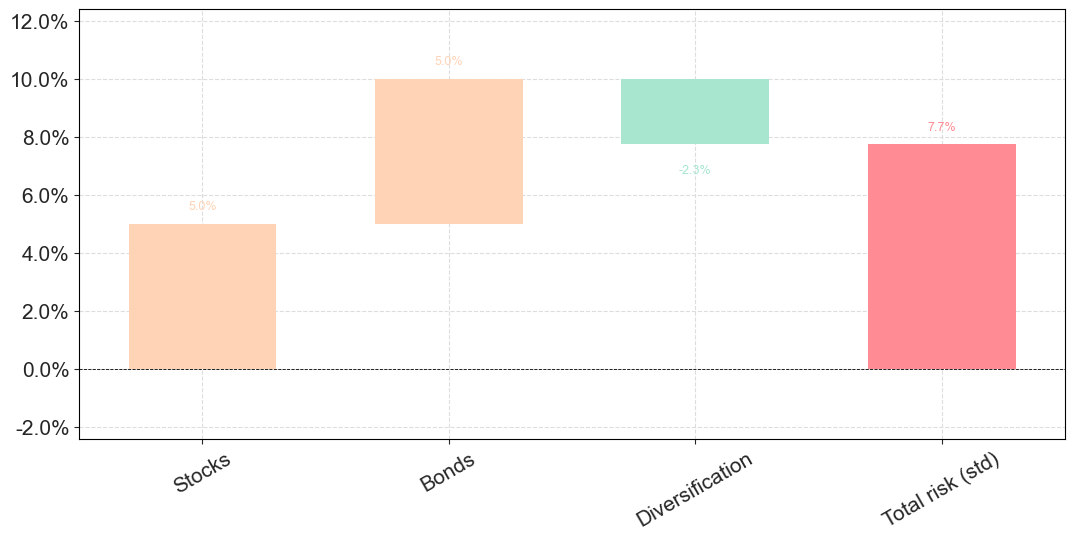

In [17]:
"""
Implement the solution from Bruder and Roncalli (2012)
"""

def weights_risk_budget(sigma1: float, sigma2: float, rho: float, b: float) -> Tuple[float, float]:
    
    """
    Function that calculates the portfolio weights that result in equal risk contribution. Two asset case. 
    
    Parameters
    ----------
    sigma1: 
        Std. of asset 1
    sigma2: 
        Std. of asset 2
    rho: 
        Correlation between asset 1 and asset 2
    b: 
        Risk contribution from asset 1
    
    Returns
    -------
    np.ndarray
       Optimal weigths. 
    
    """
    
    num = (b - 0.5)*rho*sigma1*sigma2 - b*sigma2**2 + sigma1*sigma2*np.sqrt((b-0.5)**2*rho**2 + b*(1-b))
    den = (1-b)*sigma1**2 - b*sigma2**2 + 2*(b-0.5)*rho*sigma1*sigma2
    
    w_opt = num / den 
    
    return w_opt, 1 - w_opt


w_eq_risk = weights_risk_budget(sigma_s, sigma_b, rho, 0.5)

print("Port. weights:")
print("Stocks: {:.2f}%'".format(w_eq_risk[0] * 100))
print("Bonds: {:.2f}%'".format(w_eq_risk[1] * 100))

"""
Calculate total risk and div. benefit
"""

total_port_risk = portfolio_std(w_eq_risk, cov_mat)
div_benefit = total_port_risk - w_eq_risk @ vols

print('\nThe diversification benefit is equal to {:.2f}%'.format(div_benefit * 100))

"""
Plot a waterfall chart with risk decomposition 
"""

fig, ax = risk_waterfall_chart(vols * w_eq_risk * 100, total_port_risk * 100, names=["Stocks", "Bonds"],
                     formatting='{:,.1f}%', total_risk_label="Total risk (std)", diversification_label="Diversification")

fig.set_size_inches(12, 6);

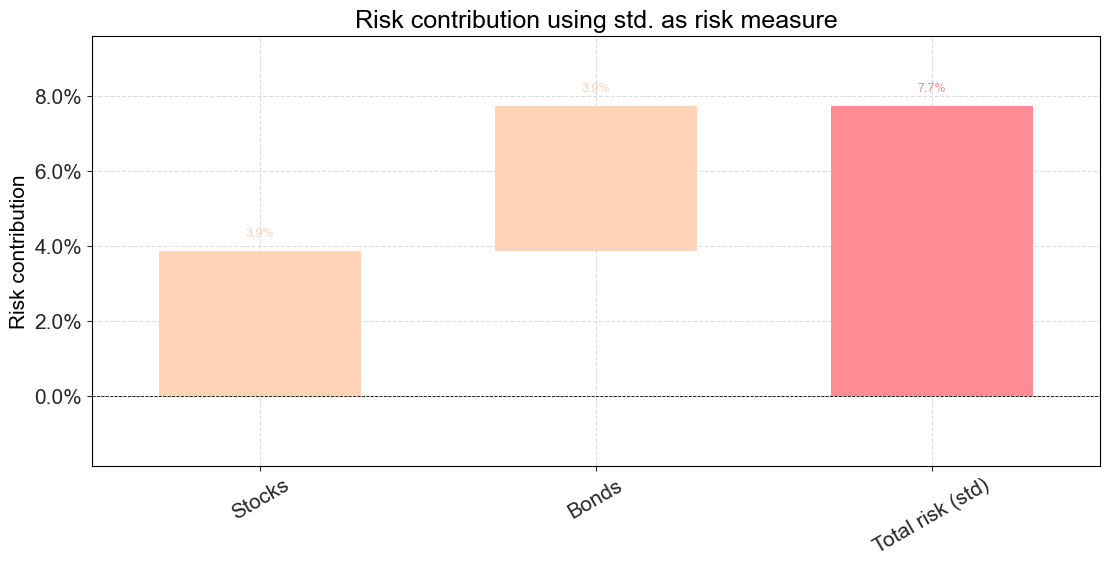

In [18]:
risk_contrib = calculate_risk_contributions(w_eq_risk, cov_mat)

fig, ax = waterfall_chart(values=risk_contrib*100,
                          labels=["Stocks", "Bonds"],
                          formatting='{:,.1f}%',
                          total_label="Total risk (std)")

ax.set(ylabel="Risk contribution", title="Risk contribution using std. as risk measure")

fig.set_size_inches(12, 6);

# References

## Articles
[Artzner et al (1999), "Coherent Measures of Risks"](https://onlinelibrary.wiley.com/doi/abs/10.1111/1467-9965.00068)

[Bruder and Roncalli (2012), "Managing Risk Exposures using
the Risk Budgeting Approach"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2009778)

[Rosen and Saunders (2010), "Risk factor contributions in portfolio credit risk models"](https://onlinelibrary.wiley.com/doi/abs/10.1111/1467-9965.00068)

## Books

[Attilio Meucci, "Risk and Asset Allocation"](https://www.amazon.com/Risk-Asset-Allocation-Springer-Finance/dp/3642009646)